#  Intro to Gibbs Sampling

##### Keywords: MCMC, gibbs sampler, transition matrix, autocorrelation

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm, gamma
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')

## TL;DR
Gibbs sampling is a Metropolis-Hastings procedure with a very specfic proposal distribution: the conditional distribution of one of the sampled variables at the present value of all the remaining variables. It cycles through updating various blocks.

It is ideal when you have the conditional distributions and not the joint distribution, which happens surprisingly often in practice.

## Contents
{:.no_toc}
* 
{: toc}

## The Situation
Gibbs sampling takes in two (or more) conditional distributions and gives us samples from the _joint_ distribution that has those conditionals.

First, this should seem like magic. It's not instantly clear that $f(y|X=x)$ and $g(x|Y=y)$ have enough information to uniquely specifiy $P(X=x,Y=y)$ in the first place, let alone sample from it. (Marginal distributions certainly aren't enough to specifiy a joint distribution, unless the variables are independent)

It turns out, though, that a 3d shape can be reubilt from 2d cross-sections along each axis, so there is enough information in the conditionals and sampling is actually pretty easy.


## The Plan
Gibbs' idea is to start at a random point $(x_{old},y_{old})$, and draw a sample $y_{new}$ from the $f(y|X=x_{old})$ distribution. Then it draws a sample $x_{new}$ from $g(x|Y=y_{old})$ distribution. The process updates to the point $(x_{new},y_{new})$ and repeats. Over time, the set of $(x,y)$ pairs form a sample from the overall joint distribution.

We'll prove why Gibbs works in a moment; first, let's see THAT it works.

## An example

Let us consider a 2-D distribution which we wish to sample from.

$$f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$$

#### X conditional
$$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)]{\rm exp}[- y^2 + 2y]$$
$$f(x|y) = g(y){\rm Gamma}(3,y^2+4)$$

#### Y conditional
$$f(y|x) = x^2 {\rm exp}[-(1+x)(y^2 - 2y\frac{1}{1+x} + \frac{1}{(1+x)^2})]{\rm exp}[-4x]$$
$$f(y|x) = h(x)Normal\left(\frac{1}{1+x},\frac{1}{\sqrt{(2(1+x))}}\right) $$

$h(x)$ is unimportant for sampling a y value given X=x, as x will be fixed, so we can just draw from the apropriate normal distribution. Likewise for $g(y)$.

We'll do the math to find these conditionals in the appendix. In general, though, Gibbs is at its best when you have conditionals but not the joint, as invariably happens in Hierarchical or Graphical models. (We just want an example where we can apply Gibbs and also show the known joint distribution)

Here's what the distribution really looks like.

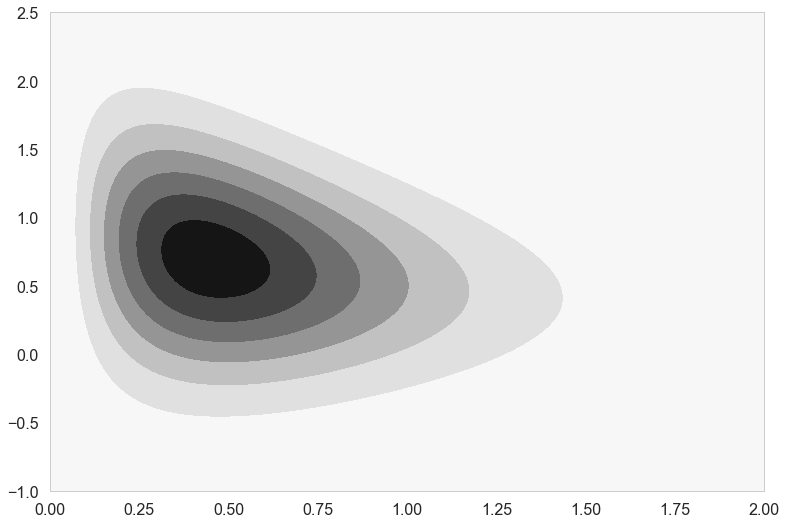

In [2]:
def joint(x,y): 
    return x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x)

def xcond(y):
    return gamma.rvs(3, scale=1/(y*y + 4))

def ycond(x):
    return norm.rvs(1/(1+x), scale=1.0/np.sqrt(2*(x+1)))

numgridpoints=400
x = np.linspace(0,2,numgridpoints)
y = np.linspace(-1,2.5,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j]=joint(xx[i,j],yy[i,j])
        
plt.contourf(xx,yy,zz);

## The sampler

In [3]:
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

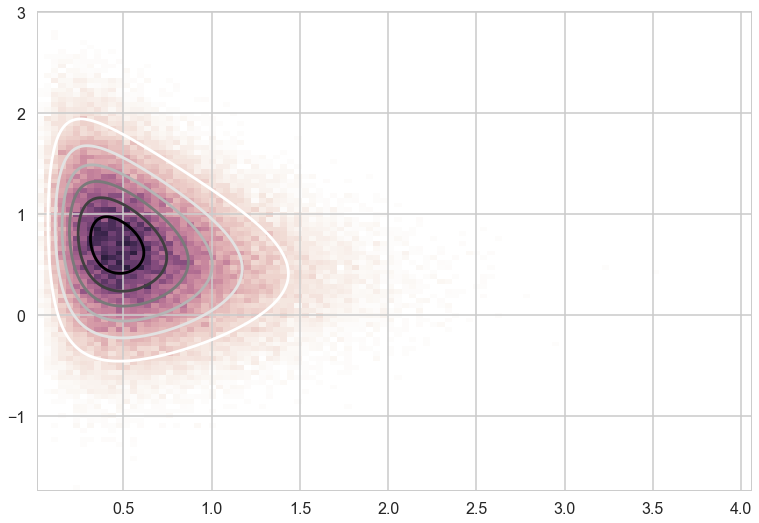

In [4]:
out=gibbs(xcond, ycond, 100000)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[10000:,0],out[10000:,1], normed=True, bins=100, cmap=cmap)
plt.contour(xx,yy,zz)
plt.show()

### Gibbs Moves

Let's look at the single steps the Gibbs sampler is taking:

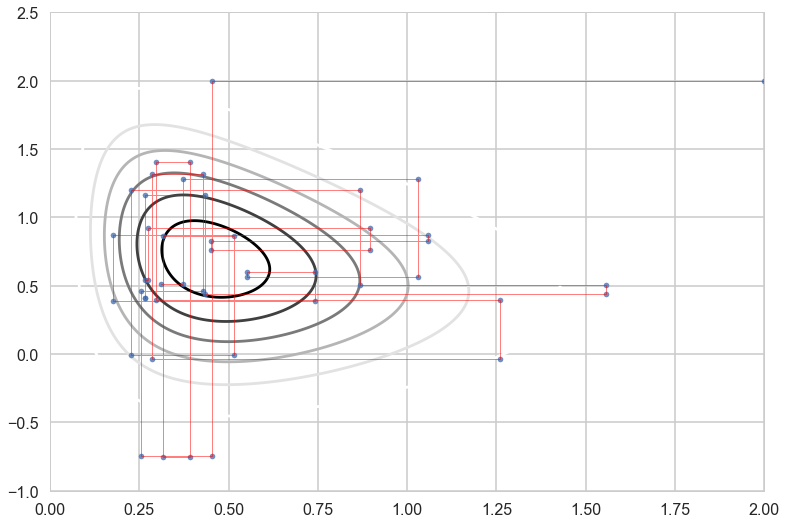

In [5]:
out=gibbs(xcond, ycond, 10000, start = [2,2])
nr_t = 50
plt.contour(xx,yy,zz)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], '.',alpha=0.8)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], c='r', alpha=0.5, lw=1);

So the gibbs sampler wanders through the space much like a MH sampler, but Gibbs only moves at right angles. Gibbs also burns in in a hurry on single-peak distributions: look at how the first two steps go from really far away to right into the thick of things. Furthermore, Gibbs fusses not-at-all with things like proposal width: the proposals are completely defined for us as the conditional distributions, and these are in some sense the optimal proposal distributions at each x or y value (though we give up being able to move diagonally)

#### Convergence checking
The usual diagnostic checks (autocorrelation, effective sample size, Gelman and Geweke) all still apply.

## More than two variables
If we have e.g. 5 variables to sample from a 5-way joint distribution we can use any set of conditionals we want. 

- We could have $p(x_1|x_2,x_3,x_4,x_5)$ and $p(x_2|x_1,x_3,x_4,x_5)$ and  $p(x_3|x_1,x_2,x_4,x_5)$ and so on for all 5 variables. 
- We could instead have just $p(x_2,x_5|x_1,x_3,x_4)$ and $p(x_1,x_3,x_4|x_2,x_5)$. 
- We could have $p(x_1|x_2,x_3,x_4,x_5)$, $p(x_2,x_5|x_1,x_3,x_4)$, and $p(x_3,x_4|x_1,x_2,x_5)$. 

In the first case we'd cycle through all 5 conditionals, in the second we'd cycle through two updates [update $x_2,x_5$ simultaneously, update $x_1,x_3,x_4$ simultaneously], and the third case would have a cycle of three updates.

## Why it works: Gibbs is a special case of MH
Although it can be proved that Gibbs works in its own right, Gibbs is easiest to understand as a form of Metropolis-Hastings, and the description should just REEK of MH. We pick a random starting point, we get a proposed point from a distribution, and we converge over time. 

The key differences with MH are that 1) we always accept the move, 2) we don't use the same tranition matrix/conditional distribution all the time. If we're at (3,4) sometimes we're about to make a proposal from the X conditional, and sometimes we're about to make a proposal from the Y conditional.

Always accepting the move is nice, but needs to be justified. We'll do that below. 

Multiple transition matrices can be understood as keeping more state than just the current x and y values. We could say that states in the chain (and our samples from it) look like (x,y,0) or (x,y,1) instead of just (x,y), indicating we're at the point x,y and about to update x or about to update y, repsectively. Here, The transition rule inspects the auxilary variable to decide what to do, updates the auxilary variable, and runs the appropriate sub-update. The overall update process is the same at all times, even if the branch taken depends on the state.

In essence, we work with $T(x,y,aux|X=x,Y=y,Aux=i)$ and it happens that if aux=1 we put probability 0 on anything that changes $x$. (And likewise for y and aux=0). When we want to get the distribution for X and Y, we marginalize over aux. In sampling terms, we just drop the aux column from all our samples.

[This is our first taste of data augmentation: by keeping an aux variable that we end up ignoring, we get to transform MH into Gibbs and not futz with proposal widths and accept/reject. We'll later see how traking extra variables helps in other contexts, too]


### Proof
We need to show that Gibbs Sampling converges to our target distribution. In particular, we need to show that using the conditional distributions means we can skip the "do we accept?" check that MH otherwise requires. 

So, write out the update Gibbs is doing. We'll tackle the case of component-wise updating. (bullet 1 above). [If you want to prove block-wise updating, pretend that $x_{k}^i$ is the two or more variables being updated, instead of just the one variable being updated. Nothing else changes]

We shall use the following notation, assuming that $x$ is multidimensional: $x_{k}^i$ is the $k$th component of $x$ at $i$th step, while $x_{-k}^i$ is all other componets of $x$ at the same step. Anything with a star on it is a proposed point.

Gibbs uses the proposal function:

$$q_k(x^* \vert x^i) = \begin{cases} p(x_k^* \vert x_{-k}^i) & for \,\,x_{-k}^* = x_{-k}^i,\\ 0 & otherwise \end{cases}$$

![](images/gibbsograph.png)

In other words, you propose from the conditional distribution of the current component, given a fixed $x_{old}$ value of the other components.  You keep all the other component values the same. If you change any of the old component values, the proposal probability is 0.

Definitionally, our MH acceptance probability term is:

$$A = min(1, \frac{p(x^*)}{p(x^i)}\,\frac{q_k(x^i \vert x^*)}{q_k(x^* \vert x^i)})$$

We use $p(x^*) = p(x_{-k}^*, x_k^*) = p(x_{k}^* \vert  x_{-k}^*)p(x_{-k}^*)$ to obtain

$$A = min(1, \frac{p(x_{k}^* \vert  x_{-k}^*)p(x_{-k}^*)}{p(x_{k}^i \vert  x_{-k}^i)p(x_{-k}^i)}\,\frac{q_k(x^i \vert x^*)}{q_k(x^* \vert x^i)})$$

Putting in the definition of the proposal, we get

$$A = min(1, \frac{p(x_{k}^* \vert  x_{-k}^*)p(x_{-k}^*)}{p(x_{k}^i \vert  x_{-k}^i)p(x_{-k}^i)}\,\frac{p(x_k^i \vert x_{-k}^*)}{p(x_k^* \vert x_{-k}^i)})$$

Now, because of the componentwise update, $x_{-k}^* = x_{-k}^i$ [all the non-k variables don't change as we update them] and thus we get the middle 2 terms in the numerator and denominator cancelling, and the 1st and 3rd terms from the numerator cancelling the 3rd and 1st terms respectively. Thus our acceptance probability is always 1. 

We have constructed a MH sampler with no rejection!!

## Appendix: Finding the conditional distributions

We have:

$$f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$$

#### X conditional
Now assume we hold $y$ constant:

$$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)]{\rm exp}[- y^2 + 2y]$$

$$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)] g(y)$$

where $g(y) = {\rm exp}[- y^2 + 2y]$. Thus:

$$f(x|y) = g(y){\rm Gamma}(3,y^2+4)$$

#### Y conditional
Next, assume we hold $x$ constant...

$$f(y|x) = x^2 {\rm exp}[-y^2(1+x) + 2y]{\rm exp}[-4x]$$

$$f(y|x) = x^2 {\rm exp}[-y^2(1+x) +2y - \frac{1}{1+x}]\, {\rm exp}[-4x]\,{\rm exp}[\frac{1}{1+x}]$$

$$f(y|x) = x^2 {\rm exp}[-(1+x)(y^2 - 2y\frac{1}{1+x} + \frac{1}{(1+x)^2})]{\rm exp}[-4x]$$

Writing $h(x) = x^2 {\rm exp}[-4x]$ we have 

$$f(y|x) = N(\frac{1}{1+x},\frac{1}{\sqrt{(2(1+x))}}) h(x)$$